In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from IPython.display import display
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import tensorflow as tf
import io
tf.keras.backend.set_floatx('float64')
import imageio
import os   #This module provides a portable way of using operating system dependent functionality. 
from tqdm import tqdm_notebook as tqdm #used for progress bar in loops

from IPython.display import HTML as html_print


In [2]:
# Dataset
!yes | wget "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

--2022-05-08 12:36:30--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   216MB/s    in 9.4s    

2022-05-08 12:36:39 (205 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [3]:
# Unzip
!yes | tar xopf dakshina_dataset_v1.0.tar

In [2]:
from matplotlib.font_manager import FontProperties
hi_font = FontProperties(fname = 'nirmala.ttf', size=18) 

In [4]:
train = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"
def dataset(data_file):
    hindi = []
    latin = []
    with io.open(data_file, encoding ='utf-8') as f:
        for line in f:
            if '\t' not in line:
                continue
            tokens = line.rstrip().split("\t")
            latin.append(tokens[1])
            hindi.append(tokens[0])
    return latin, hindi

tr_src, tr_trgt = dataset(train)
val_src, val_trgt = dataset(val)
ts_src, ts_trgt = dataset(test)

print("Num train: ", len(tr_src))
print("Numb val: ", len(val_src))
print("Num test: ", len(ts_src))

Num train:  44204
Numb val:  4358
Num test:  4502


In [6]:
iter_tr = np.arange(len(tr_src))
np.random.shuffle(iter_tr)
iter_val = np.arange(len(val_src))
np.random.shuffle(iter_val)

char_inpts = set()
char_tar = set()
text_inpts = []
text_trgts = []
inpts_val = []
trgts_val = []

for (txt_inp, target_text) in zip(tr_src, tr_trgt):
    target_text = "B" + target_text + "E"
    text_inpts.append(txt_inp)
    text_trgts.append(target_text)
    for char in txt_inp:
        if char not in char_inpts:
            char_inpts.add(char)
    for char in target_text:
        if char not in char_tar:
            char_tar.add(char)

for (txt_inp, target_text) in zip(val_src, val_trgt):
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "B" + target_text + "E"
    inpts_val.append(txt_inp)
    trgts_val.append(target_text)
    for char in txt_inp:
        if char not in char_inpts:
            char_inpts.add(char)
    for char in target_text:
        if char not in char_tar:
            char_tar.add(char)

txt_inps = []
txt_trgt = []

for i in range(len(tr_src)):
    txt_inps.append(text_inpts[iter_tr[i]])
    txt_trgt.append(text_trgts[iter_tr[i]])

txt_inps_val = []
txt_trgt_val = []

for i in range(len(val_src)):
    txt_inps_val.append(inpts_val[iter_val[i]])
    txt_trgt_val.append(trgts_val[iter_val[i]])

char_inpts.add(" ")
char_tar.add(" ")

char_inpts = sorted(list(char_inpts))
char_tar = sorted(list(char_tar))

enc_num = len(char_inpts)
dec_num = len(char_tar)
enc_mx = max([len(txt) for txt in txt_inps])
dec_mx = max([len(txt) for txt in txt_trgt])
enc_mx_val = max([len(txt) for txt in txt_inps_val])
dec_mx_val = max([len(txt) for txt in txt_trgt_val])



print("Num samples:", len(txt_inps))
print("Number of unique input tokens:", enc_num)
print("Number of unique output tokens:", dec_num)
print("Max sequence length for inputs:", enc_mx)
print("Max sequence length for outputs:", dec_mx)
print("Max sequence length for val inputs:", enc_mx_val)
print("Max sequence length for val outputs:", dec_mx_val)

print(char_inpts)
print(char_tar)

Number of samples: 44204
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21
Max sequence length for val inputs: 18
Max sequence length for val outputs: 16
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[' ', 'B', 'E', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'ॐ']


In [7]:
idx_inp = dict([(char, i) for i, char in enumerate(char_inpts)])
idx_tar = dict([(char, i) for i, char in enumerate(char_tar)])
idx_inp_rev = dict((i, char) for char, i in idx_inp.items())
idx_tar_rev = dict((i, char) for char, i in idx_tar.items())
print(idx_inp)
print(idx_tar)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{' ': 0, 'B': 1, 'E': 2, 'ँ': 3, 'ं': 4, 'ः': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ए': 13, 'ऐ': 14, 'ऑ': 15, 'ओ': 16, 'औ': 17, 'क': 18, 'ख': 19, 'ग': 20, 'घ': 21, 'ङ': 22, 'च': 23, 'छ': 24, 'ज': 25, 'झ': 26, 'ञ': 27, 'ट': 28, 'ठ': 29, 'ड': 30, 'ढ': 31, 'ण': 32, 'त': 33, 'थ': 34, 'द': 35, 'ध': 36, 'न': 37, 'प': 38, 'फ': 39, 'ब': 40, 'भ': 41, 'म': 42, 'य': 43, 'र': 44, 'ल': 45, 'व': 46, 'श': 47, 'ष': 48, 'स': 49, 'ह': 50, '़': 51, 'ा': 52, 'ि': 53, 'ी': 54, 'ु': 55, 'ू': 56, 'ृ': 57, 'ॅ': 58, 'े': 59, 'ै': 60, 'ॉ': 61, 'ो': 62, 'ौ': 63, '्': 64, 'ॐ': 65}


In [8]:
txt_inp_sl = txt_inps[:44160]
txt_tar_sl = txt_trgt[:44160]

inp_enc = np.zeros(
    (len(txt_inp_sl), enc_mx, enc_num), dtype="float64"
)
tar_dec = np.zeros(
    (len(txt_inp_sl), dec_mx, dec_num), dtype="float64"
)

for i, (txt_inp, target_text) in enumerate(zip(txt_inp_sl, txt_tar_sl)):
    for t, char in enumerate(txt_inp):
        inp_enc[i, t, idx_inp[char]] = 1.0
    inp_enc[i, t + 1 :, idx_inp[" "]] = 1.0
    for t, char in enumerate(target_text):
        tar_dec[i, t, idx_tar[char]] = 1.0
    tar_dec[i, t + 1 :, idx_tar[" "]] = 1.0
    
inp_enc_val = np.zeros(
    (len(txt_inps_val), enc_mx, enc_num), dtype="float64"
)
tar_dec_val = np.zeros(
    (len(txt_trgt_val), dec_mx, dec_num), dtype="float64"
)

for i, (txt_inp, target_text) in enumerate(zip(txt_inps_val, txt_trgt_val)):
    for t, char in enumerate(txt_inp):
        inp_enc_val[i, t, idx_inp[char]] = 1.0
    inp_enc_val[i, t + 1 :, idx_inp[" "]] = 1.0

    for t, char in enumerate(target_text):
        tar_dec_val[i, t, idx_tar[char]] = 1.0
    tar_dec_val[i, t + 1: ,idx_tar[" "]] = 1.0
  


# ATTENTION MECHANISM 

In [9]:
class atten_badh(tf.keras.layers.Layer):
    def __init__(self, units):
        super(atten_badh, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        qwt_ax = tf.expand_dims(query, 1)

        sc = self.V(tf.nn.tanh(
            self.W1(qwt_ax) + self.W2(values)))
        att_w = tf.nn.softmax(sc, axis=1)
        c_v = att_w * values
        c_v = tf.reduce_sum(c_v, axis=1)
        return c_v, att_w


In [10]:
class seq_atten(object):
    def __init__(self,ty = 'RNN', hs=32, 
                   lr= 1e-3,drp=0.3,epochs = 10, bs = 32,
                   atten = 'bahd'):

        self.ty = ty
        self.hs = hs
        self.lr = lr
        self.drp = drp
        self.epochs = epochs
        self.bs = bs
        self.atten = atten

    def fit(self,inp_enc,tar_dec):

        enc_inp_temp = Input(shape=(enc_mx, enc_num), name='enc_inp_temp')
        if self.ty == 'LSTM':
            enc_lstm = LSTM(self.hs,ret_seq=True, return_state=True, drp = self.drp, name='enc_lstm')
            enc_outputs, enc_state_h, enc_state_c = enc_lstm(enc_inp_temp)
            enc_states = [enc_state_h, enc_state_c]
        elif self.ty == 'GRU':
            enc_gru = GRU(self.hs,ret_seq=True, return_state=True, drp = self.drp, name='enc_gru')
            enc_outputs, enc_state_h = enc_gru(enc_inp_temp)
            enc_states = [enc_state_h]
        elif self.ty == 'RNN':
            enc_rnn = SimpleRNN(self.hs,ret_seq=True, return_state=True, drp = self.drp, name='enc_rnn')
            enc_outputs, enc_state_h = enc_rnn(enc_inp_temp)
            enc_states = [enc_state_h]

        if self.atten == 'bahd':
            atten= atten_badh(self.hs)

        dec_inputs = Input(shape=(1, (dec_num+self.hs)),name='dec_inputs')
        if self.ty== 'LSTM':
            dec_lstm = LSTM(self.hs, drp = self.drp, return_state=True, name='dec_lstm')
        elif self.ty == 'GRU':
            dec_gru = GRU(self.hs, drp = self.drp, return_state=True, name='dec_gru')
        elif self.ty == 'RNN':
            dec_rnn = SimpleRNN(self.hs, drp = self.drp, return_state=True, name='dec_rnn')  

        dec_dense = Dense(dec_num, activation='softmax',  name='dec_dense')

        all_outputs = []

        inputs = np.zeros((self.bs, 1, dec_num))
        inputs[:, 0, 0] = 1 

        dec_outputs = enc_state_h
        states = enc_states

        for _ in range(dec_mx):

            con_vec, atten_weights=atten(dec_outputs, enc_outputs)

            con_vec = tf.expand_dims(con_vec, 1)

            inputs = tf.concat([con_vec, inputs], axis=-1)
            if self.ty == 'LSTM':
                dec_outputs, state_h, state_c = dec_lstm(inputs, initial_state=states)
            if self.ty == 'GRU':
                dec_outputs, state_h = dec_gru(inputs, initial_state=states)
            if self.ty == 'RNN':
                dec_outputs, state_h = dec_rnn(inputs, initial_state=states)

            outputs = dec_dense(dec_outputs)
            outputs = tf.expand_dims(outputs, 1)
            all_outputs.append(outputs)
            inputs = outputs
            if self.ty == 'LSTM':
                states = [state_h, state_c]
            if self.ty == 'GRU' or self.ty == 'RNN':
                states = [state_h]


        dec_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

        model = Model(enc_inp_temp, dec_outputs, name='model_enc_dec')

        optimizer = Adam(lr=self.lr, beta_1=0.9, beta_2=0.999)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        #model.summary()

        model.fit(inp_enc, tar_dec,
                  bs=self.bs, 
                  epochs=self.epochs,
                  )
        if self.ty== 'LSTM':
            return enc_lstm,atten,dec_lstm,dec_dense
        if self.ty == 'GRU':
            return enc_gru,atten,dec_gru,dec_dense
        if self.ty== 'RNN':
            return enc_rnn,atten,dec_rnn,dec_dense  

    def evaluate(self,seq_in):
        atten_plot = np.zeros((dec_mx, enc_mx))
        sequence = seq_in
        enc_inp_temp=array(sequence).reshape(1,enc_mx,enc_num)

        enc_inp_temp = tf.convert_to_tensor(enc_inp_temp,dtype=tf.float32)

        if self.ty == 'LSTM':
            enc_outputs, enc_state_h, enc_state_c = enc(enc_inp_temp)
            enc_states = [enc_state_h, enc_state_c]
        elif self.ty == 'GRU':
            enc_outputs, enc_state_h = enc(enc_inp_temp)
            enc_states = [enc_state_h]
        elif self.ty == 'RNN':
            enc_outputs, enc_state_h = enc(enc_inp_temp)
            enc_states = [enc_state_h]

        all_outputs = []

        dec_input_data = np.zeros((1, 1, dec_num))
        dec_input_data[:, 0, 0] = 1 

        inputs = dec_input_data
        dec_outputs = enc_state_h
        states = enc_states

        weigh_atten =[]
        for t in range(dec_mx):
            con_vec, atten_weights = atten(dec_outputs, enc_outputs)

            atten_weights = tf.reshape(atten_weights, (-1, ))
            weigh_atten.append(atten_weights)

            atten_plot[t] = atten_weights.numpy()

            dec_outputs=tf.expand_dims(dec_outputs, 1)

            con_vec = tf.expand_dims(con_vec, 1)
            inputs = tf.concat([con_vec, inputs], axis=-1)

            if self.ty == 'LSTM':
                dec_outputs, state_h, state_c = dec(inputs, initial_state=states)
            if self.ty == 'GRU':
                dec_outputs, state_h = dec(inputs, initial_state=states)
            if self.ty == 'RNN':
                dec_outputs, state_h = dec(inputs, initial_state=states)

            outputs = dec_dense(dec_outputs)
            outputs = tf.expand_dims(outputs, 1)
            all_outputs.append(outputs)
            inputs = outputs
            if self.ty == 'LSTM':
                states = [state_h, state_c]
            if self.ty == 'GRU' or self.ty == 'RNN':
                states = [state_h]

        dec_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
        seq_outs = dec_outputs[0]
        seq_out = tf.argmax(seq_outs, axis=1)
        seq_out = seq_out.numpy()
        seq_in = tf.argmax(seq_in, axis = 1)
        seq_in = seq_in.numpy()
        list(filter(lambda num: num != 0, seq_in))
        list(filter(lambda num: num != 0, seq_out))

        return seq_in, seq_out, atten_plot, weigh_atten

    def plot_atten(self,atten, sequence, predicted_sequence):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(atten, cmap='viridis')

        fontdict = {'fontsize': 30}
        seq = ''
        for i in range(len(sequence)):
            seq = seq + idx_inp_rev[sequence[i]]

        pred = ''
        for i in range(len(predicted_sequence)):
            pred = pred + idx_tar_rev[predicted_sequence[i]]
        print(pred)
        #ax.rcParams["font.family"] = "Vijaya"
        ax.set_xticklabels(seq, fontdict=fontdict)
        ax.set_yticklabels(pred, fontdict=fontdict, fontproperties = hi_font)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    def translate(self,seq_in):
        seq_in, seq_out, atten_plot, weigh_atten = self.evaluate(seq_in)

        a = [0]
        for i in range(len(seq_in)):
              if seq_in[i] != 0:
                a.append(seq_in[i])

        b = []
        for i in range(len(seq_out)):
              if seq_out[i] != 0:
                b.append(seq_out[i])

        b = b[:len(b)-1]
        print(a)
        print(b)

        atten_plot = atten_plot[:len(b), :len(a)]
        self.plot_atten(atten_plot, a, b)  

        return weigh_atten

    def atten_plot(self,val_input):
        seq_in = val_input
        weigh_atten = self.translate(seq_in)  
        return weigh_atten

In [11]:
model = seq_atten(ty = 'LSTM', hs=128, lr= 1e-3,
                        drp=0.2,epochs = 15, bs = 128, atten = 'bahd')

In [12]:
enc,atten,dec,dec_dense = model.fit(inp_enc,tar_dec)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
345/345 [==============================] - 99s 164ms/step - loss: 1.3121 - accuracy: 0.6806
Epoch 2/15
345/345 [==============================] - 56s 163ms/step - loss: 1.1182 - accuracy: 0.7023
Epoch 3/15
345/345 [==============================] - 57s 164ms/step - loss: 1.0403 - accuracy: 0.7145
Epoch 4/15
345/345 [==============================] - 56s 164ms/step - loss: 0.9718 - accuracy: 0.7268
Epoch 5/15
345/345 [==============================] - 57s 164ms/step - loss: 0.9147 - accuracy: 0.7381
Epoch 6/15
345/345 [==============================] - 56s 163ms/step - loss: 0.8663 - accuracy: 0.7493
Epoch 7/15
345/345 [==============================] - 56s 163ms/step - loss: 0.8277 - accuracy: 0.7581
Epoch 8/15
345/345 [==============================] - 56s 164ms/step - loss: 0.7947 - accuracy: 0.7660
Epoch 9/15
345/345 [==============================] - 56s 163ms/step - loss: 0.7648 - accuracy: 0.7729
Epoch 10/15
345/345 [==============================] - 56s 164ms/step - l

[0, 19, 21, 18, 1, 11, 19, 8, 9, 20]
[1, 49, 55, 44, 52, 64, 48, 48, 33]
Bसुरा्षषत


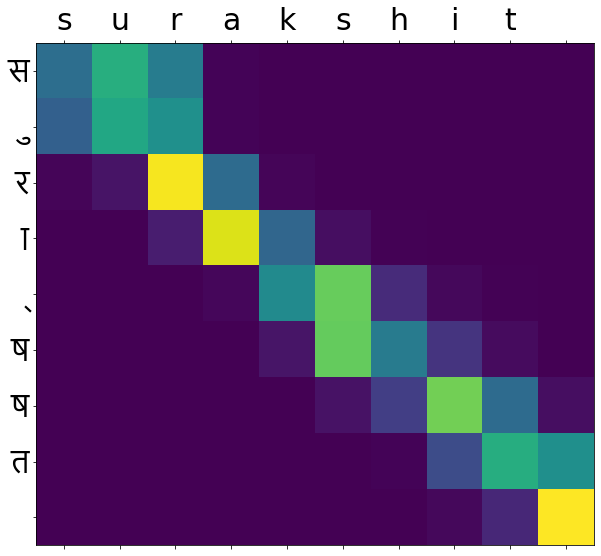

In [17]:
w_a = model.atten_plot(inp_enc_val[3])

In [27]:
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

In [28]:
eng = [19, 21, 18, 1, 11, 19, 8, 9, 20]
hin = [49, 55, 44, 52, 64, 48, 48, 33]

eng_rev = ''
for i in range(len(eng)):
    eng_rev = eng_rev + idx_inp_rev[eng[i]]

hin_rev = ''
for i in range(len(hin)):
    hin_rev = hin_rev + idx_tar_rev[hin[i]]

print(eng_rev) 
print(hin_rev)

len_eng = len(eng)
len_hin = len(hin)
print(len_eng)
print(len_hin)

for i in range(len(hin)):
    print(idx_tar_rev[hin[i]])

surakshit
सुरा्षषत
9
8
स
ु
र
ा
्
ष
ष
त


In [77]:
from PIL import Image
def visualize(output_values, result_list,k):
    text_colours = []
    for i in range(len_eng):
        text = (result_list[i], get_clr(output_values[i]))
        text_colours.append(text)
        if i == len_eng-1:
            html_file = open(str(k)+".html", "w")
            html_file.write(''.join([cstr(ti, color=ci) for ti,ci in text_colours]))
            html_file.close()
            display(html_print(''.join([cstr(ti, color=ci) for ti,ci in text_colours])))

In [78]:
for j in range(len_hin):
    visualize(w_a[j][:], eng_rev,j)